In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import trace_tries
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_step = combinators.PrimitiveCall(ssm.ssm_step)
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_sequence = combinators.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1), initializer=ssm_initializer)

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = combinators.PrimitiveCall(ssm.ssm_step)
ssm_generative = combinators.Reduce(ssm_step_generative, generator=lambda: range(50), initializer=init_ssm_generative)

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = combinators.PrimitiveCall(ssm.ssm_step)
ssm_proposal = importance.smc(ssm_step_proposal, particle_shape, lambda: range(50), initializer=init_ssm_proposal)

In [11]:
ssm_score = combinators.score_under_proposal(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_score, 1000, data, use_cuda=False,
    lr=1e-2, patience=100
)

11/09/2018 14:17:30 ELBO=-6.65095901e+01 at epoch 1
11/09/2018 14:17:30 ELBO=-6.39612274e+01 at epoch 2
11/09/2018 14:17:30 ELBO=-6.29283981e+01 at epoch 3
11/09/2018 14:17:30 ELBO=-6.61831589e+01 at epoch 4
11/09/2018 14:17:30 ELBO=-6.63370972e+01 at epoch 5
11/09/2018 14:17:30 ELBO=-6.29316444e+01 at epoch 6
11/09/2018 14:17:30 ELBO=-6.26968307e+01 at epoch 7
11/09/2018 14:17:30 ELBO=-6.64228821e+01 at epoch 8
11/09/2018 14:17:30 ELBO=-6.65504150e+01 at epoch 9
11/09/2018 14:17:30 ELBO=-6.56650085e+01 at epoch 10
11/09/2018 14:17:31 ELBO=-6.33199539e+01 at epoch 11
11/09/2018 14:17:31 ELBO=-6.62340393e+01 at epoch 12
11/09/2018 14:17:31 ELBO=-6.43403244e+01 at epoch 13
11/09/2018 14:17:31 ELBO=-6.82716217e+01 at epoch 14
11/09/2018 14:17:31 ELBO=-6.19194336e+01 at epoch 15
11/09/2018 14:17:31 ELBO=-6.43629150e+01 at epoch 16
11/09/2018 14:17:31 ELBO=-6.23962975e+01 at epoch 17
11/09/2018 14:17:31 ELBO=-6.39474030e+01 at epoch 18
11/09/2018 14:17:31 ELBO=-6.57901230e+01 at epoch 19
11

Epoch   268: reducing learning rate of group 0 to 5.0000e-03.


11/09/2018 14:17:50 ELBO=-6.38164558e+01 at epoch 272
11/09/2018 14:17:50 ELBO=-6.32996864e+01 at epoch 273
11/09/2018 14:17:51 ELBO=-6.29032936e+01 at epoch 274
11/09/2018 14:17:51 ELBO=-6.26523819e+01 at epoch 275
11/09/2018 14:17:51 ELBO=-6.33489952e+01 at epoch 276
11/09/2018 14:17:51 ELBO=-6.38334579e+01 at epoch 277
11/09/2018 14:17:51 ELBO=-6.47539139e+01 at epoch 278
11/09/2018 14:17:51 ELBO=-6.41105347e+01 at epoch 279
11/09/2018 14:17:51 ELBO=-6.28776512e+01 at epoch 280
11/09/2018 14:17:51 ELBO=-6.35085335e+01 at epoch 281
11/09/2018 14:17:51 ELBO=-6.31730728e+01 at epoch 282
11/09/2018 14:17:51 ELBO=-6.31783600e+01 at epoch 283
11/09/2018 14:17:51 ELBO=-6.25395012e+01 at epoch 284
11/09/2018 14:17:51 ELBO=-6.15740623e+01 at epoch 285
11/09/2018 14:17:51 ELBO=-6.25773964e+01 at epoch 286
11/09/2018 14:17:52 ELBO=-6.19689674e+01 at epoch 287
11/09/2018 14:17:52 ELBO=-6.29697380e+01 at epoch 288
11/09/2018 14:17:52 ELBO=-6.15639877e+01 at epoch 289
11/09/2018 14:17:52 ELBO=-6.

Epoch   454: reducing learning rate of group 0 to 2.5000e-03.


11/09/2018 14:18:04 ELBO=-6.47880478e+01 at epoch 458
11/09/2018 14:18:04 ELBO=-6.44477081e+01 at epoch 459
11/09/2018 14:18:04 ELBO=-6.34545250e+01 at epoch 460
11/09/2018 14:18:04 ELBO=-6.31737175e+01 at epoch 461
11/09/2018 14:18:04 ELBO=-6.30104675e+01 at epoch 462
11/09/2018 14:18:04 ELBO=-6.36804886e+01 at epoch 463
11/09/2018 14:18:04 ELBO=-6.24808273e+01 at epoch 464
11/09/2018 14:18:04 ELBO=-6.35021133e+01 at epoch 465
11/09/2018 14:18:04 ELBO=-6.50853958e+01 at epoch 466
11/09/2018 14:18:04 ELBO=-6.05585938e+01 at epoch 467
11/09/2018 14:18:04 ELBO=-6.26734047e+01 at epoch 468
11/09/2018 14:18:05 ELBO=-6.14731445e+01 at epoch 469
11/09/2018 14:18:05 ELBO=-6.16545105e+01 at epoch 470
11/09/2018 14:18:05 ELBO=-6.23963470e+01 at epoch 471
11/09/2018 14:18:05 ELBO=-6.33931923e+01 at epoch 472
11/09/2018 14:18:05 ELBO=-6.39427872e+01 at epoch 473
11/09/2018 14:18:05 ELBO=-6.45434189e+01 at epoch 474
11/09/2018 14:18:05 ELBO=-6.49420700e+01 at epoch 475
11/09/2018 14:18:05 ELBO=-6.

Epoch   555: reducing learning rate of group 0 to 1.2500e-03.


11/09/2018 14:18:11 ELBO=-6.56794739e+01 at epoch 559
11/09/2018 14:18:11 ELBO=-6.44631195e+01 at epoch 560
11/09/2018 14:18:11 ELBO=-6.30134964e+01 at epoch 561
11/09/2018 14:18:11 ELBO=-6.32107124e+01 at epoch 562
11/09/2018 14:18:11 ELBO=-6.57024460e+01 at epoch 563
11/09/2018 14:18:11 ELBO=-6.31988220e+01 at epoch 564
11/09/2018 14:18:11 ELBO=-6.48115234e+01 at epoch 565
11/09/2018 14:18:11 ELBO=-6.50824509e+01 at epoch 566
11/09/2018 14:18:11 ELBO=-6.59616699e+01 at epoch 567
11/09/2018 14:18:11 ELBO=-6.28301659e+01 at epoch 568
11/09/2018 14:18:11 ELBO=-6.51937714e+01 at epoch 569
11/09/2018 14:18:11 ELBO=-6.14888496e+01 at epoch 570
11/09/2018 14:18:11 ELBO=-6.44389725e+01 at epoch 571
11/09/2018 14:18:11 ELBO=-6.64484940e+01 at epoch 572
11/09/2018 14:18:12 ELBO=-6.66556702e+01 at epoch 573
11/09/2018 14:18:12 ELBO=-6.44493866e+01 at epoch 574
11/09/2018 14:18:12 ELBO=-6.39107094e+01 at epoch 575
11/09/2018 14:18:12 ELBO=-6.42233810e+01 at epoch 576
11/09/2018 14:18:12 ELBO=-6.

Epoch   709: reducing learning rate of group 0 to 6.2500e-04.


11/09/2018 14:18:21 ELBO=-6.62597885e+01 at epoch 713
11/09/2018 14:18:21 ELBO=-6.60052795e+01 at epoch 714
11/09/2018 14:18:21 ELBO=-6.45864258e+01 at epoch 715
11/09/2018 14:18:21 ELBO=-6.44634552e+01 at epoch 716
11/09/2018 14:18:21 ELBO=-6.47186432e+01 at epoch 717
11/09/2018 14:18:22 ELBO=-6.33984756e+01 at epoch 718
11/09/2018 14:18:22 ELBO=-6.41849899e+01 at epoch 719
11/09/2018 14:18:22 ELBO=-6.48538895e+01 at epoch 720
11/09/2018 14:18:22 ELBO=-6.44621506e+01 at epoch 721
11/09/2018 14:18:22 ELBO=-6.35211372e+01 at epoch 722
11/09/2018 14:18:22 ELBO=-6.34290009e+01 at epoch 723
11/09/2018 14:18:22 ELBO=-6.53967972e+01 at epoch 724
11/09/2018 14:18:22 ELBO=-6.47660446e+01 at epoch 725
11/09/2018 14:18:22 ELBO=-6.48444061e+01 at epoch 726
11/09/2018 14:18:22 ELBO=-6.35780449e+01 at epoch 727
11/09/2018 14:18:22 ELBO=-6.43103104e+01 at epoch 728
11/09/2018 14:18:22 ELBO=-6.51283340e+01 at epoch 729
11/09/2018 14:18:22 ELBO=-6.27665825e+01 at epoch 730
11/09/2018 14:18:22 ELBO=-6.

Epoch   810: reducing learning rate of group 0 to 3.1250e-04.


11/09/2018 14:18:28 ELBO=-6.22569046e+01 at epoch 814
11/09/2018 14:18:28 ELBO=-6.73343353e+01 at epoch 815
11/09/2018 14:18:28 ELBO=-6.40074081e+01 at epoch 816
11/09/2018 14:18:28 ELBO=-6.56912155e+01 at epoch 817
11/09/2018 14:18:28 ELBO=-6.62450333e+01 at epoch 818
11/09/2018 14:18:28 ELBO=-6.22089539e+01 at epoch 819
11/09/2018 14:18:28 ELBO=-6.31005135e+01 at epoch 820
11/09/2018 14:18:28 ELBO=-6.42224655e+01 at epoch 821
11/09/2018 14:18:28 ELBO=-6.44148788e+01 at epoch 822
11/09/2018 14:18:28 ELBO=-6.67442627e+01 at epoch 823
11/09/2018 14:18:28 ELBO=-6.49032211e+01 at epoch 824
11/09/2018 14:18:28 ELBO=-6.52073288e+01 at epoch 825
11/09/2018 14:18:29 ELBO=-6.42038040e+01 at epoch 826
11/09/2018 14:18:29 ELBO=-6.54999924e+01 at epoch 827
11/09/2018 14:18:29 ELBO=-6.46680527e+01 at epoch 828
11/09/2018 14:18:29 ELBO=-6.31708679e+01 at epoch 829
11/09/2018 14:18:29 ELBO=-6.44520035e+01 at epoch 830
11/09/2018 14:18:29 ELBO=-6.41846695e+01 at epoch 831
11/09/2018 14:18:29 ELBO=-6.

Epoch   911: reducing learning rate of group 0 to 1.5625e-04.


11/09/2018 14:18:34 ELBO=-6.45564651e+01 at epoch 916
11/09/2018 14:18:34 ELBO=-6.44001389e+01 at epoch 917
11/09/2018 14:18:35 ELBO=-6.50169220e+01 at epoch 918
11/09/2018 14:18:35 ELBO=-6.43801422e+01 at epoch 919
11/09/2018 14:18:35 ELBO=-6.52632294e+01 at epoch 920
11/09/2018 14:18:35 ELBO=-6.44694366e+01 at epoch 921
11/09/2018 14:18:35 ELBO=-6.32044106e+01 at epoch 922
11/09/2018 14:18:35 ELBO=-6.49090042e+01 at epoch 923
11/09/2018 14:18:35 ELBO=-6.42965851e+01 at epoch 924
11/09/2018 14:18:35 ELBO=-6.05837250e+01 at epoch 925
11/09/2018 14:18:35 ELBO=-6.24835091e+01 at epoch 926
11/09/2018 14:18:35 ELBO=-6.57804031e+01 at epoch 927
11/09/2018 14:18:35 ELBO=-6.74597855e+01 at epoch 928
11/09/2018 14:18:35 ELBO=-6.53826294e+01 at epoch 929
11/09/2018 14:18:35 ELBO=-6.44902496e+01 at epoch 930
11/09/2018 14:18:35 ELBO=-6.49683456e+01 at epoch 931
11/09/2018 14:18:35 ELBO=-6.48440399e+01 at epoch 932
11/09/2018 14:18:35 ELBO=-6.64704590e+01 at epoch 933
11/09/2018 14:18:35 ELBO=-6.

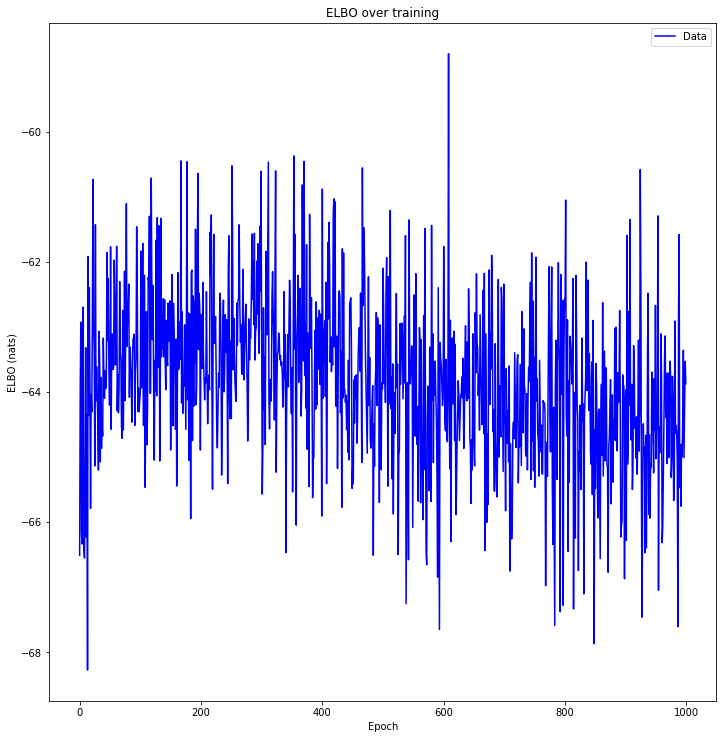

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 0.827066
SMC MSE at time 2: 0.814260
SMC MSE at time 3: 0.617077
SMC MSE at time 4: 1.068842
SMC MSE at time 5: 1.124261
SMC MSE at time 6: 4.265686
SMC MSE at time 7: 0.922105
SMC MSE at time 8: 1.942732
SMC MSE at time 9: 1.452310
SMC MSE at time 10: 3.689026
SMC MSE at time 11: 1.033089
SMC MSE at time 12: 1.053032
SMC MSE at time 13: 0.628850
SMC MSE at time 14: 1.010186
SMC MSE at time 15: 0.524973
SMC MSE at time 16: 0.594894
SMC MSE at time 17: 0.623755
SMC MSE at time 18: 0.926312
SMC MSE at time 19: 0.580402
SMC MSE at time 20: 0.534146
SMC MSE at time 21: 0.639993
SMC MSE at time 22: 0.881107
SMC MSE at time 23: 1.004464
SMC MSE at time 24: 0.790306
SMC MSE at time 25: 0.479121
SMC MSE at time 26: 0.733722
SMC MSE at time 27: 1.704190
SMC MSE at time 28: 1.901114
SMC MSE at time 29: 0.618895
SMC MSE at time 30: 0.697558
SMC MSE at time 31: 1.200625
SMC MSE at time 32: 0.630189
SMC MSE at time 33: 0.956221
SMC MSE at time 34: 0.855845
SMC MSE at time 35: 2.4

In [15]:
particle_mh = mcmc.IndependentMH(ssm_score, 1000)

In [16]:
lookup = utils.dict_lookup(data)
inference = trace_tries.HierarchicalTrace(observations=lookup)
samples, inference = particle_mh(trace=inference)

In [17]:
inference

In [18]:
generative

In [19]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

KeyError: 'Reduce(ssm_step)'

In [ ]:
elbos